In [172]:
import matplotlib.pyplot as plt

def draw(V, adj_V):  
  # draw vertices
  for v in V:
    plt.plot(V[:,0], V[:,1], 'bo')
  
  # draw edges
  for i in range(len(V)):
    v = V[i]
    for j in adj_V[i]:
      w = V[j]
      xs = [v[0], w[0]]
      ys = [v[1], w[1]]
      plt.plot(xs, ys, 'b-')
  plt.show()
  
def bfs(v, adj_V):
  vis = [v]
  vis.extend(adj_V[v])
  q = list(adj_V[v])
  while len(q) > 0:
    w = q.pop(0)
    for u in adj_V[w]:
      if u not in vis:
        vis.append(u)
        q.append(u)
  return vis

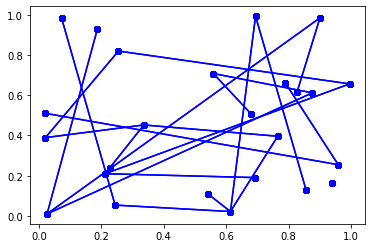

In [208]:
import numpy as np

V = np.random.rand(25, 2)

# create random adjacency list
adj_V = {}
for i in range(len(V)):
  adj = np.random.randint(0, len(V) - 1, np.random.randint(0, 3))
  adj = adj[adj != i]
  adj_V[i] = adj
  
# make adjacency list symmetric
for i in range(len(V)):
  for nbr in adj_V[i]:
    if i not in adj_V[nbr]:
      adj_V[nbr] = np.append(adj_V[nbr], [i])
      
draw(V, adj_V)